## Qwen2.5-VL


In [1]:
!pip install -q transformers accelerate sentencepiece pymupdf pillow python-Levenshtein huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 120.4 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login
login()


In [3]:
import time, re, csv
import fitz
from PIL import Image
import Levenshtein
import torch
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoProcessor, AutoModelForVision2Seq


Ladda GOLD.txt (Facit)


In [4]:
from google.colab import files
print("Ladda upp GOLD.txt (Docling-export)")
uploaded_gt = files.upload()

gold_path = list(uploaded_gt.keys())[0]

with open(gold_path, "r") as f:
    gold_md = f.read()

print("GOLD loaded:", gold_path)


Ladda upp GOLD.txt (Docling-export)


Saving gold.txt to gold.txt
GOLD loaded: gold.txt


Ladda PDF-filen

In [5]:
print("Ladda upp PDF som ska benchmarkas:")
uploaded_pdf = files.upload()

pdf_path = list(uploaded_pdf.keys())[0]
print("PDF:", pdf_path)


Ladda upp PDF som ska benchmarkas:


Saving pdf_test.pdf to pdf_test.pdf
PDF: pdf_test.pdf


Konvertera PDF till bilder

In [7]:
def pdf_to_images(pdf_path):
    t0 = time.time()
    doc = fitz.open(pdf_path)
    pages = []

    for page in doc:
        pix = page.get_pixmap(dpi=180)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        pages.append(img)

    print(f"PDF till bilder klart: {time.time()-t0:.2f}s ({len(pages)} sidor)")
    return pages

pages = pdf_to_images(pdf_path)


PDF till bilder klart: 27.82s (68 sidor)


Hjälpfunktioner för:
- CER/WER
- Similarity score
- Headings
- Struktur

In [8]:
def cer(ref, hyp):
    ref = ref.replace("\n","")
    hyp = hyp.replace("\n","")
    return Levenshtein.distance(ref, hyp) / max(1, len(ref))

def wer(ref, hyp):
    ref_w = ref.split()
    hyp_w = hyp.split()
    return Levenshtein.distance(" ".join(ref_w), " ".join(hyp_w)) / max(1, len(ref_w))

def similarity(ref, hyp):
    return Levenshtein.ratio(ref, hyp)

def count_headings(md):
    return len(re.findall(r"^#{1,6} ", md, flags=re.MULTILINE))


## Qwen2.5-VL modell

In [9]:
def load_qwen(model_id):
    print(f"Laddar: {model_id}")
    t0 = time.time()
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForVision2Seq.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    print(f"Klar på {time.time()-t0:.1f}s\n")
    return processor, model

processor25, model25 = load_qwen("Qwen/Qwen2.5-VL-7B-Instruct")


Laddar: Qwen/Qwen2.5-VL-7B-Instruct


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

Klar på 66.1s



Funktion för att extrahera markdown från bild

In [10]:
import numpy as np
import torch
import time

def extract_with_qwen(img, processor, model):

    # PIL till NumPy
    np_img = np.array(img)

    # Bygg chat-meddelandet
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": np_img},
                {"type": "text", "text": "Extract all text and document structure. Return ONLY Markdown."}
            ]
        }
    ]

    # Använd apply_chat_template för att få ENDAST den bearbetade textsträngen
    input_text = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False  # Se till att den returnerar den råa strängen
    )

    # Bearbeta strängen OCH bilden samtidigt
    model_inputs = processor(
        text=input_text,
        images=[np_img],
        return_tensors="pt"
    )

    # Flytta tensors till GPU och konvertera dtype
    # Flytta textdelarna
    model_inputs["input_ids"] = model_inputs["input_ids"].to("cuda")
    model_inputs["attention_mask"] = model_inputs["attention_mask"].to("cuda")

    # Flytta och konvertera visuella delar
    if "pixel_values" in model_inputs:
        model_inputs["pixel_values"] = model_inputs["pixel_values"].to("cuda", torch.float16)
    if "image_grid_thw" in model_inputs:
        model_inputs["image_grid_thw"] = model_inputs["image_grid_thw"].to("cuda")


    # Kör generering
    t0 = time.time()
    output = model.generate(
        **model_inputs,
        max_new_tokens=4096
    )
    t1 = time.time()

    md = processor.decode(output[0], skip_special_tokens=True)
    return md, (t1 - t0)

Benchmark för båda modellerna

In [11]:
qwen25_pages = []
qwen25_times = []

for idx, img in enumerate(pages):
    print(f"[Qwen2.5] Sida {idx+1}/{len(pages)}...")

    md25, t25 = extract_with_qwen(img, processor25, model25)

    qwen25_pages.append(md25)
    qwen25_times.append(t25)
    print(f"  Klar på {t25:.2f} sek")


[Qwen2.5] Sida 1/68...
  Klar på 7.20 sek
[Qwen2.5] Sida 2/68...
  Klar på 65.36 sek
[Qwen2.5] Sida 3/68...
  Klar på 7.59 sek
[Qwen2.5] Sida 4/68...
  Klar på 109.25 sek
[Qwen2.5] Sida 5/68...
  Klar på 70.19 sek
[Qwen2.5] Sida 6/68...
  Klar på 111.65 sek
[Qwen2.5] Sida 7/68...
  Klar på 277.00 sek
[Qwen2.5] Sida 8/68...
  Klar på 69.84 sek
[Qwen2.5] Sida 9/68...
  Klar på 7.89 sek
[Qwen2.5] Sida 10/68...
  Klar på 64.30 sek
[Qwen2.5] Sida 11/68...
  Klar på 41.35 sek
[Qwen2.5] Sida 12/68...
  Klar på 59.98 sek
[Qwen2.5] Sida 13/68...
  Klar på 276.72 sek
[Qwen2.5] Sida 14/68...
  Klar på 74.13 sek
[Qwen2.5] Sida 15/68...
  Klar på 17.21 sek
[Qwen2.5] Sida 16/68...
  Klar på 32.67 sek
[Qwen2.5] Sida 17/68...
  Klar på 71.77 sek
[Qwen2.5] Sida 18/68...
  Klar på 276.56 sek
[Qwen2.5] Sida 19/68...
  Klar på 39.62 sek
[Qwen2.5] Sida 20/68...
  Klar på 79.81 sek
[Qwen2.5] Sida 21/68...
  Klar på 86.99 sek
[Qwen2.5] Sida 22/68...
  Klar på 12.57 sek
[Qwen2.5] Sida 23/68...
  Klar på 84.35

In [35]:
qwen25_md ="\n\n---\n\n".join(qwen25_pages)
print(qwen25_md[:1000])


system
You are a helpful assistant.
user
Extract all text and document structure. Return ONLY Markdown.
assistant
$\text { Årsredovisning }$

2022

FLEXQUBE®

---

system
You are a helpful assistant.
user
Extract all text and document structure. Return ONLY Markdown.
assistant
```markdown
| FlexQube är en global leverantör av modulära och robusta mekaniska vagnar och robotiserade lösningar för materialhantering. Koncernen grundades 2010 och har sedan dess säkrat ett stort antal framstående företag som kunder. |
| --- |
| FlexQube är ett teknikbolag med huvudkontor i Göteborg samt egna verksamheter i USA, Mexiko, Tyskland och England. Bolaget är verksamt inom vagnsbaserad materialhantering genom ett patenterat modulkoncept. FlexQube utvecklar och designar kundanpassade lösningar för både robotiserad och mekaniserad vagnslogistik. Genom företagets egenutvecklade och unika automationskoncept erbjuds robusta och självkörande robotvagnar. FlexQube har över 1000 kunder i 37 länder där de pri

Spara Qwen2.5 output i .md och .json

In [18]:
import json

# Spara full markdown
with open("qwen25_output.md", "w", encoding="utf-8") as f:
    f.write("\n\n---\n\n".join(qwen25_md))

# Spara tidsdata
with open("qwen25_times.json", "w", encoding="utf-8") as f:
    json.dump(qwen25_times, f)

# sammanfattning
summary25 = {
    "total_time_sec": sum(qwen25_times),
    "avg_time_sec": sum(qwen25_times) / len(qwen25_times),
    "pages": len(qwen25_times),
}

with open("qwen25_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary25, f, indent=2)

print(" Qwen2.5-VL resultat sparade!")


 Qwen2.5-VL resultat sparade!


Metrik för modellen och gold.txt

In [19]:
def evaluate_model(name, md, times):
    return {
        "model": name,
        "CER": cer(gold_md, md),
        "WER": wer(gold_md, md),
        "Similarity": similarity(gold_md, md),
        "Headings": count_headings(md),
        "Total time (sec)": sum(times)
    }

results = []

results.append(evaluate_model("Qwen2.5-VL", qwen25_md, qwen25_times))

df = pd.DataFrame(results)
df



,model,CER,WER,Similarity,Headings,Total time (sec)
0,Qwen2.5-VL,0.540791,3.10532,0.672656,191,5633.328351


In [38]:
import re

def count_headings_only(md):
    return len(re.findall(r"^#{1,6}\s", md, flags=re.MULTILINE))

gold_headings_count = count_headings_only(gold_md)
qwen_headings_count = count_headings_only(qwen25_md)

print("===== Rubrikräkning =====")
print(f"Antal rubriker i GOLD: {gold_headings_count}")
print(f"Antal rubriker i Qwen2.5-VL: {qwen_headings_count}")


===== Rubrikräkning =====
Antal rubriker i GOLD: 347
Antal rubriker i Qwen2.5-VL: 191


## Visualisering

In [7]:
from google.colab import files

print("Ladda upp qwen25_output.md")
uploaded = files.upload()

qwen25_path = list(uploaded.keys())[0]

with open(qwen25_path, "r", encoding="utf-8") as f:
    qwen25_md = f.read()

print("Qwen25 markdown laddad! Fil:", qwen25_path)


Ladda upp qwen25_output.md


Saving qwen25_output.md to qwen25_output.md
Qwen25 markdown laddad! Fil: qwen25_output.md


In [31]:
import fitz
from PIL import Image
import time


# Ladda Qwen25
with open("qwen25_output.md", "r", encoding="utf-8") as f:
    qwen25_md = f.read()

print("Qwen25 markdown laddad!")

# ladda PDF till bilder för att kunna jämföra sida för sida
def pdf_to_images(pdf_path):
    doc = fitz.open(pdf_path)
    pages = []
    for page in doc:
        pix = page.get_pixmap(dpi=180)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        pages.append(img)
    return pages

pages = pdf_to_images(pdf_path)
print("Antal sidor i PDF:", len(pages))


Qwen25 markdown laddad!
Antal sidor i PDF: 68


In [32]:
# Dela upp Qwen-output per sida
qwen_pages = qwen25_md.split("\n\n---\n\n")


Antal Qwen-sidor: 68


In [38]:
# Jämförelse PDF vs Qwen2.5-VL
import matplotlib.pyplot as plt
from matplotlib import gridspec

def show_pdf_vs_qwen(page_index):

    pdf_img = pages[page_index]
    qwen_page = qwen_pages[page_index]

    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(1, 2)

    # PDF-bild
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(pdf_img)
    ax1.axis("off")
    ax1.set_title(f"PDF sida {page_index+1}")

    # Qwen text
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.text(0, 1, qwen_page[:5000], fontsize=10, va='top')
    ax2.axis("off")
    ax2.set_title("Qwen OCR / Layout Output")

    plt.tight_layout()
    plt.show()


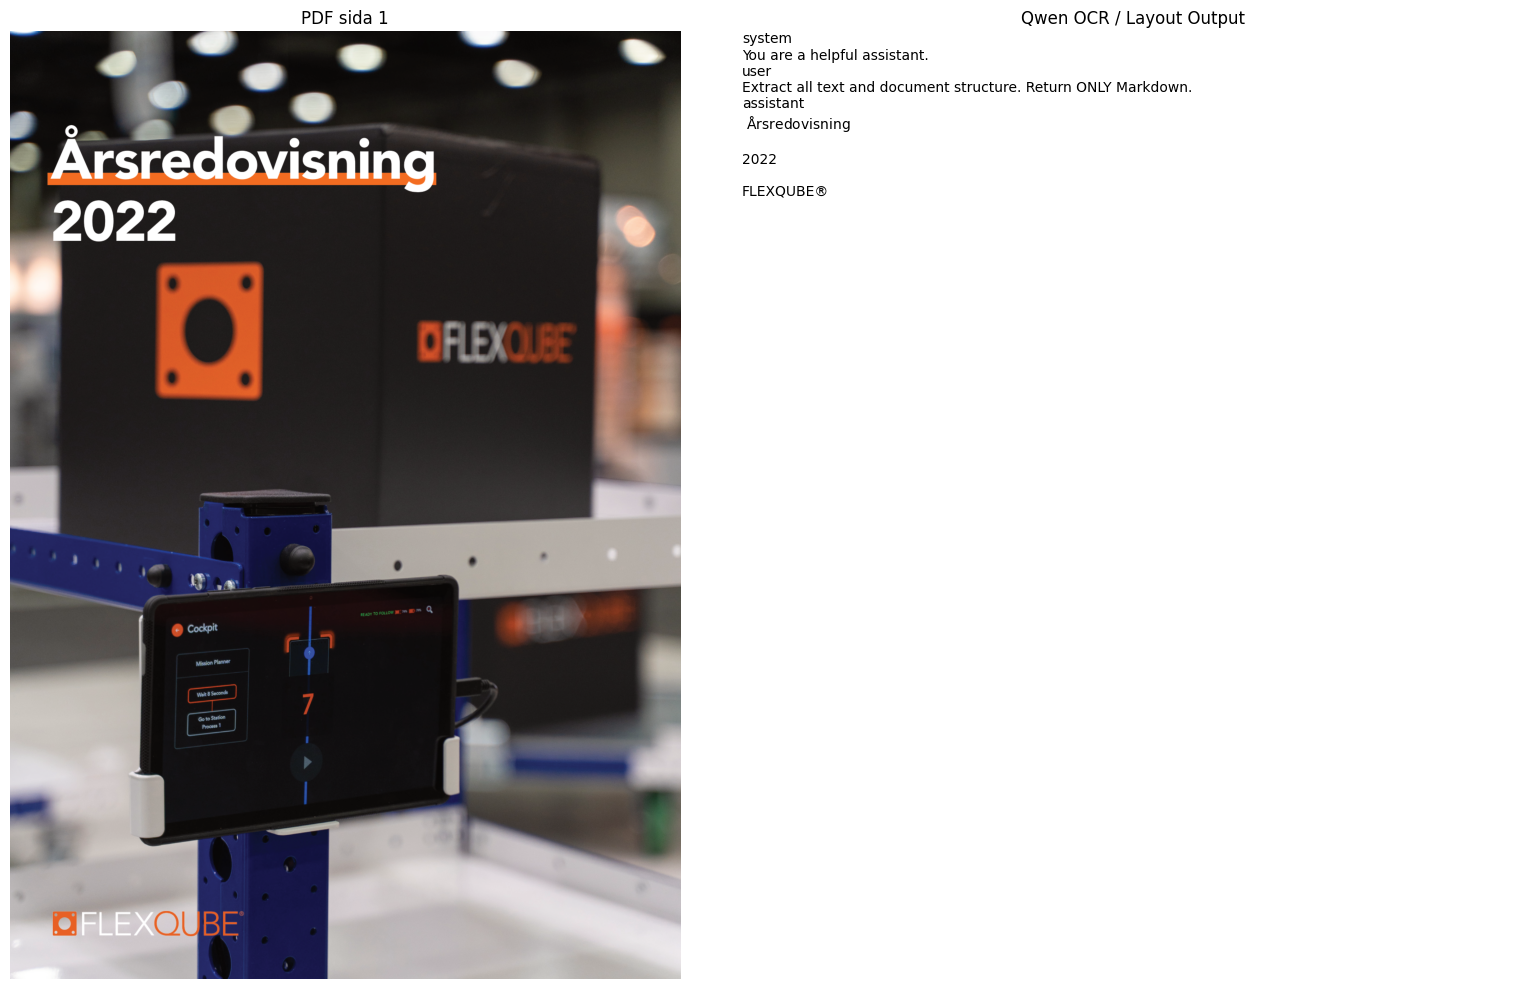

In [34]:
show_pdf_vs_qwen(0)   # Visa sida 1


/tmp/ipython-input-3802735341.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


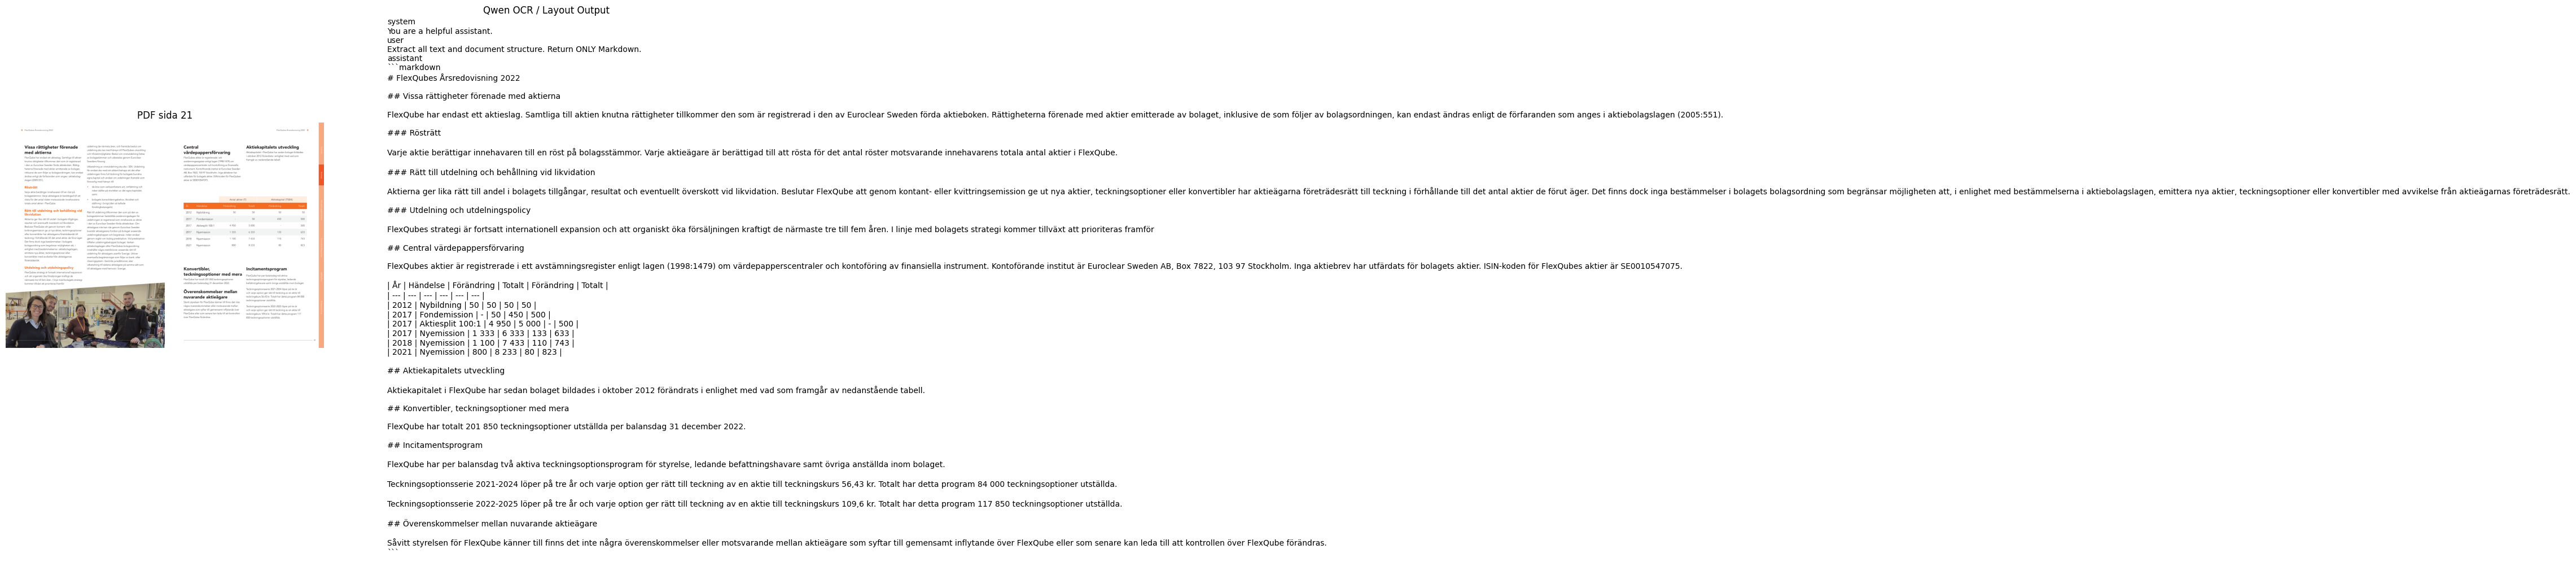

In [36]:
show_pdf_vs_qwen(20)   #sida 21

/tmp/ipython-input-3802735341.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


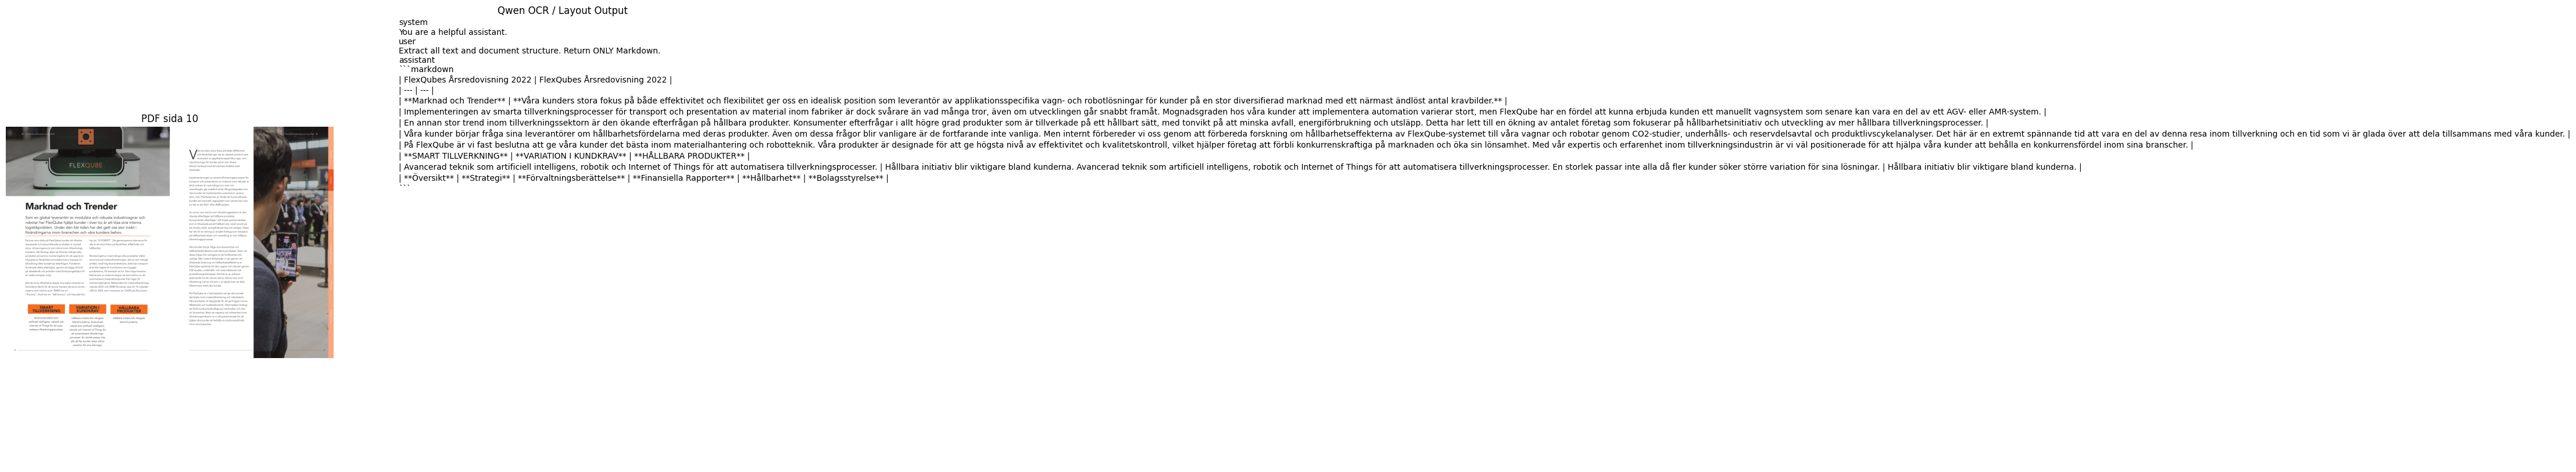

In [37]:
show_pdf_vs_qwen(9)  # sida 10


In [3]:
import os
os.listdir()


['.config', 'pdf_test.pdf', 'qwen25_output.md', 'gold.txt', 'sample_data']

In [4]:
from google.colab import files
uploaded = files.upload()


Saving Qwen2_5_VL.ipynb to Qwen2_5_VL.ipynb


In [6]:
import json

path = "Qwen2_5_VL.ipynb"

with open(path, "r", encoding="utf-8") as f:
    nb = json.load(f)

# Ta bort widgets om de finns
if "widgets" in nb.get("metadata", {}):
    del nb["metadata"]["widgets"]

with open(path, "w", encoding="utf-8") as f:
    json.dump(nb, f, indent=2)

print("Rensat: metadata.widgets borttaget!")


Rensat: metadata.widgets borttaget!
